In [542]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import random
from scipy.stats import kurtosis, skew, iqr, norm, t, laplace, beta, multivariate_normal
from PIL import Image
import cv2
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D 
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from numpy.linalg import matrix_power

# 1) Сформувати тестову вибірку зображень з вихідного пакету

In [543]:
sampleSize = 250
myNumber = 9

sampleImages = []

while len(sampleImages) != sampleSize:
    idx = random.randint(myNumber, 25000)
    image_name = f'im{idx}.jpg'
    image = cv2.imread(f'./images/{image_name}')[:, :, 1]
    sampleImages.append(image)

# 2) Провести декомпозицію каналу зеленого кольору тестових зображень з використанням методу головних компонент (PCA)

In [544]:
def pca_process(image, components = None):
    pca = PCA(n_components = components, svd_solver = 'full')
    pcaImage = pca.fit_transform(image)
    pcaImage = pca.inverse_transform(pcaImage)
    return pca, pcaImage

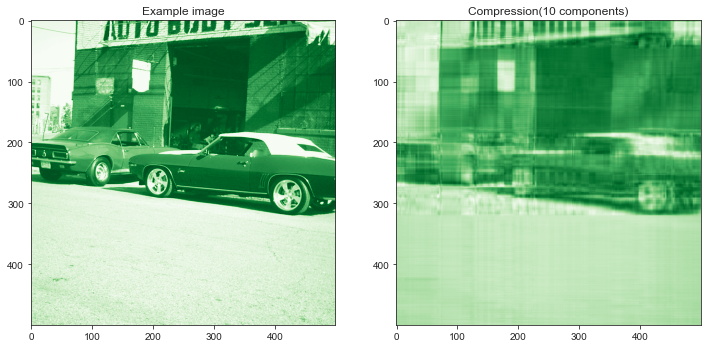

In [545]:
exampleImage = sampleImages[0]

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Example image')
plt.imshow(sampleImages[0], cmap='Greens_r')

plt.subplot(122)
plt.title('Compression(10 components)')
plt.imshow(pca_process(sampleImages[0], components=10)[1], cmap='Greens_r');

# 3) Для каналу зеленого кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:
- Впорядкувати отримані компоненти вихідного зображення в порядку зменшення значень сингулярних чисел (від найбільшого s_max до найменшого s_min значення);
- Провести реконструкцію зображення при використанні лише частки (α%) компонентів розкладу, що характеризуються відмінними від нуля сингулярними числами (s_i≠0). Розглянути випадок, коли α змінюється від α_min=10% до α_max=100% з кроком ∆_α=10%.
- Порівняти вихідне та реконструйоване зображення за показником середньоквадратичного відхилення (MSE). 
- Побудувати графіки залежності (MSE) ̅(α), де (MSE) ̅- значення середньо-квадратичного відхилення між вихідним та реконструйованим зображеннями, усереднені по тестовому пакету;


## Впорядкувати отримані компоненти вихідного зображення в порядку зменшення значень сингулярних чисел (від найбільшого s_max до найменшого s_min значення)

In [546]:
pca = pca_process(exampleImage)[0]
np.set_printoptions(threshold = 100, edgeitems = 8)
singularValues = pca.singular_values_
componentsAmount = len(singularValues)
print('Components:', componentsAmount)
print('Singular values:', singularValues)

Components: 500
Singular values: [33543.28917957 12678.89956648  9113.27272814  8244.43992777
  6993.97492282  6044.83671441  4830.03483458  4347.6756035  ...
     3.0957808      2.38243698     2.25401277     1.84129884
     1.40631193     0.74134115     0.25642206     0.        ]


## Провести реконструкцію зображення при використанні лише частки (α%) компонентів розкладу, що характеризуються відмінними від нуля сингулярними числами (s_i≠0)

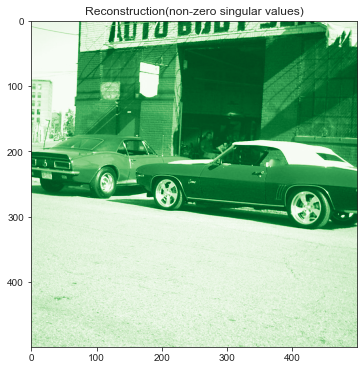

In [547]:
nComponents = len([num for num in singularValues if num != 0])

plt.figure(figsize=(6,6))
plt.title('Reconstruction(non-zero singular values)')
plt.imshow(pca_process(exampleImage, components = nComponents)[1], cmap='Greens_r');

### Розглянути випадок, коли α змінюється від α_min=10% до α_max=100% з кроком ∆_α=10%.

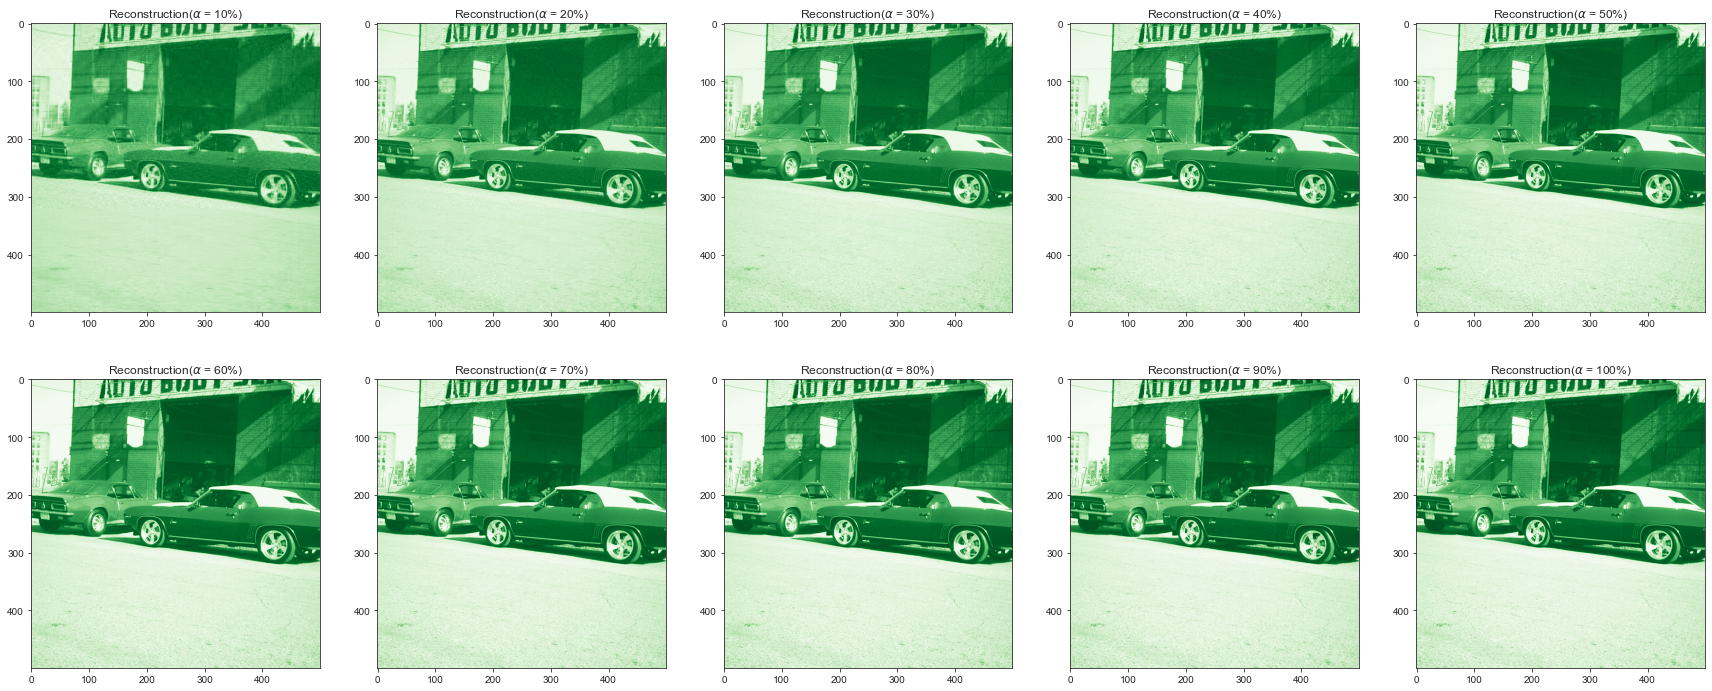

In [548]:
plt.figure(figsize=(30, 12))
for i in range(1, 10 + 1):
    nComponents = int(componentsAmount * i * 0.1)
    res = pca_process(exampleImage, components = nComponents)[1]
    plt.subplot(2, 5, i)
    plt.title('Reconstruction($\\alpha$ = {}%)'.format(i*10))
    plt.imshow(pca_process(sampleImages[0], components = nComponents)[1], cmap='Greens_r');

## Порівняти вихідне та реконструйоване зображення за показником середньоквадратичного відхилення (MSE)

MSE with 10% (50) components:  150.5745005048361
MSE with 20% (100) components:  65.55435020756357
MSE with 30% (150) components:  32.864659363974226
MSE with 40% (200) components:  16.382465278020263
MSE with 50% (250) components:  7.820351278041157
MSE with 60% (300) components:  3.3716207359062262
MSE with 70% (350) components:  1.2051534541926123
MSE with 80% (400) components:  0.3072734194894125
MSE with 90% (450) components:  0.033699905708057025
MSE with 100% (500) components:  3.8247172801141635e-25


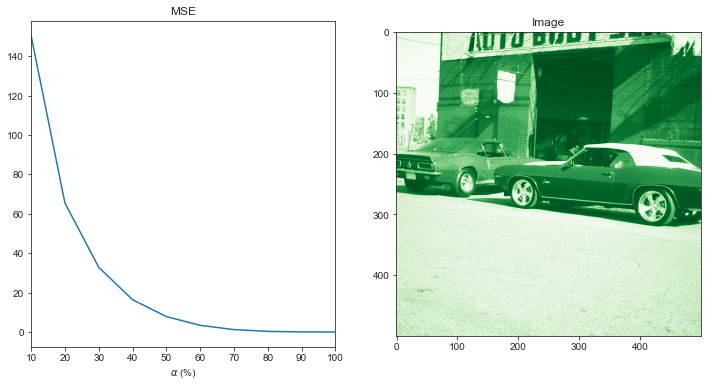

In [549]:
imageMSEs = list()
imageMSEs.append(0) # for plotting

for i in range(1, 10 + 1):
    nComponents = int(componentsAmount * i * 0.1)
    pcaImage = pca_process(exampleImage, components = nComponents)[1]
    mse = mean_squared_error(exampleImage, pcaImage)
    imageMSEs.append(mse)
    print(f'MSE with {i*10}% ({nComponents}) components: ', mse) 
        
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.xlabel('$\\alpha$ (%)')
plt.xlim([1, 10])
plt.xticks(np.arange(1,11,1), np.arange(10,101,10))
plt.title('MSE')
plt.plot(imageMSEs)
    
plt.subplot(122)
plt.title('Image')
plt.imshow(exampleImage, cmap='Greens_r')
plt.show();

## Побудувати графіки залежності (MSE) ̅(α), де (MSE) ̅- значення середньо-квадратичного відхилення між вихідним та реконструйованим зображеннями, усереднені по тестовому пакету

In [550]:
def sample_MSE(data):
    sampleMSEs = np.zeros(11)
    for image in data:
        
        imageMSEs = list()
        imageMSEs.append(0) # for plotting
        
        for i in range(1, 10 + 1):
            nComponents = int(min(image.shape[0], image.shape[1]) * i * 0.1) # "n_components == min(n_samples, n_features)" (sklearn.decomposition.PCA annotation)
            pcaImage = pca_process(image, components = nComponents)[1]
            mse = mean_squared_error(image, pcaImage)
            imageMSEs.append(mse)
            
        sampleMSEs = np.add(sampleMSEs, np.array(imageMSEs))
    return sampleMSEs / len(data)

MSE with 10% components:  205.8173506253827
MSE with 20% components:  98.27074508067285
MSE with 30% components:  52.43039740362839
MSE with 40% components:  28.098406191931335
MSE with 50% components:  14.721521065466224
MSE with 60% components:  7.237021299708508
MSE with 70% components:  3.172241381424379
MSE with 80% components:  1.1378656311464652
MSE with 90% components:  0.27019046395034507
MSE with 100% components:  5.88610471082266e-26


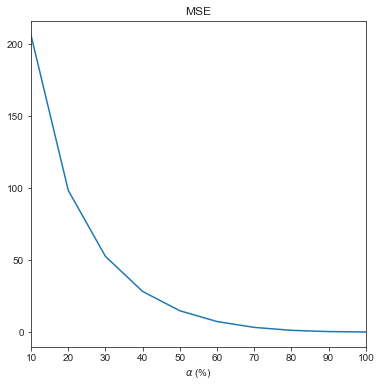

In [551]:
sampleMSEs = sample_MSE(sampleImages)
for i in range(1, 10 + 1):
    print(f'MSE with {i*10}% components: ', sampleMSEs[i])
plt.figure(figsize=(6, 6))
plt.xlabel('$\\alpha$ (%)')
plt.xlim([1, 10])
plt.xticks(np.arange(1,11,1), np.arange(10,101,10))
plt.title('MSE')
plt.plot(sampleMSEs)
plt.show()

# 4) Провести моделювання каналу зеленого кольору тестових зображень з використанням марківських ланцюгів першого порядку M_1:
- Отримати стохастичну матрицю для каналу зеленого кольору при обробці пікселів (згідно номеру студента в списку групи, за модулем кількості варіантів):
    - По горизонталі, зліва направо – M_1^→ (I_(x,y),I_(x+1,y) );
    - По горизонталі, справа наліво – M_1^← (I_(x,y),I_(x-1,y) );
    - По вертикалі, зверху вниз – M_1^↓ (I_(x,y),I_(x,y+1) );
    - По вертикалі, знизу вгору – M_1^↑ (I_(x,y),I_(x,y-1) );
    - По головній діагоналі – M_1^↘ (I_(x,y),I_(x+1,y+1) );
    - По головній діагоналі – M_1^↖ (I_(x,y),I_(x-1,y-1) );
    - По побічній діагоналі – M_1^↙ (I_(x,y),I_(x-1,y+1) );
    - По побічній діагоналі – M_1^↗ (I_(x,y),I_(x+1,y-1) );
- В протоколі роботи графічно показати вид марківського ланцюга для діапазону яскравості пікселів I_(x,y)∈[i;i×10], де i- номеру студента в списку групи;
- Для отриманих марківських ланцюгів перевірити виконання властивості регулярності та рекурентності після проходження 5 ітерацій роботи.


## Отримати стохастичну матрицю для каналу зеленого кольору при обробці пікселів (згідно номеру студента в списку групи, за модулем кількості варіантів):
#### ((( Мій номер - 9. (9 mod 8) = 1. Отже, потрібно виконати наступну обробку пікселів: )))
### По горизонталі, зліва направо – M_1^→ (I_(x,y),I_(x+1,y) )


(500, 500)


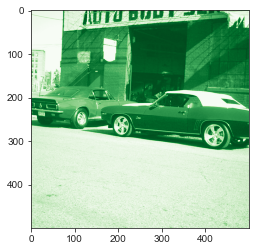

In [552]:
plt.imshow(exampleImage, cmap='Greens_r') 
print(exampleImage.shape)

In [553]:
def normalize_matrix(matrix):
    rowsSums = matrix.sum(axis = 1)
    res = matrix / rowsSums[:, None]
    return res

In [554]:
def iteration_left_right(image, matrix):
    h, w = image.shape
    for i in range(h):
        for j in range(w - 1):
            val_1 = image[i][j]
            val_2 = image[i][j + 1]
            matrix[val_2][val_1] += 1
    return matrix

In [555]:
def calculate_stochastic_matrix(data):
    stochasticMatrix = np.zeros((256, 256))
    for image in data:
        iteration_left_right(image, stochasticMatrix)
            
    stochasticMatrix = normalize_matrix(stochasticMatrix)
    return stochasticMatrix

In [556]:
def is_regular(matrix, k):
    matrix = matrix_power(matrix, k)
    return not ((matrix <= 0).sum() != 0)

In [557]:
def is_recurrent(matrix, k):
    matrix = matrix_power(matrix, k)
    for i in range(matrix.shape[0]):
        if (matrix[i] == 1).any():
            return True
    return False

## В протоколі роботи графічно показати вид марківського ланцюга для діапазону яскравості пікселів I_(x,y)∈[i;i×10], де i- номеру студента в списку групи

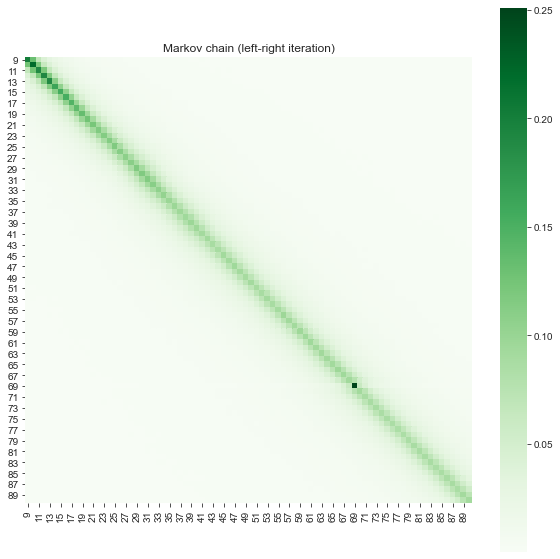

In [562]:
matrix = calculate_stochastic_matrix(sampleImages)
plt.figure(figsize=(10, 10))
plt.title('Markov chain (left-right iteration)')
ticks = np.arange(myNumber, myNumber * 10 + 1, 2)
ax = sns.heatmap(matrix[myNumber:myNumber * 10 + 1, myNumber:myNumber * 10 + 1], square=True, cmap='Greens')
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
plt.show()

## Для отриманих марківських ланцюгів перевірити виконання властивості регулярності та рекурентності після проходження 5 ітерацій роботи

In [560]:
isRegular = is_regular(matrix, k = 5)
print('Matrix is regular: ', isRegular)
isRecurrent = is_recurrent(matrix, k = 5)
print('Matrix is recurrent: ', isRecurrent)

Matrix is regular:  True
Matrix is recurrent:  False
